# ROBO TURBOSKY
The **NUMBER ONE** HELICOPTER WORKING FOR DINOCO!

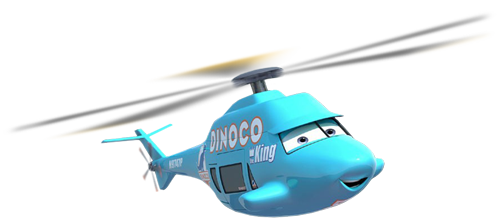

In [1]:
import torch as t
import numpy as np
from torch.utils.data import Dataset, DataLoader
from create_data2 import load_all_files, restore_scale

from tqdm.notebook import tqdm

In [2]:

#TODO: do metaidx for track_normalization values.
class TrackDataset(Dataset):
    def __init__(self, device):
        self.tracks = load_all_files("./data/electricboogaloo")
        
        self.center       = []
        self.patches      = []
        self.ai_norm      = []
        self.ai_df        = []
       # self.metaidx      = []


        for index, track in tqdm(enumerate(self.tracks), desc="Loading Tracks"):
            self.center.extend(track["center"])
            patches_np = np.array(track["track_patches"])          
            self.patches.extend(patches_np)
            self.ai_norm.extend(track["ai_norm"])
            self.ai_df.extend(track["ai_df"][["x", "z", "speed", "gas", "brake"]].values)
            #self.metaidx.extend([index] * len(track['center'])) 

        self.center       = t.tensor(np.array(self.center), dtype=t.float32)
        self.patches      = t.tensor(np.array(self.patches), dtype=t.float32)
        self.ai_norm      = t.tensor(np.array(self.ai_norm), dtype=t.float32)
        self.ai_df        = t.tensor(np.array(self.ai_df), dtype=t.float32)
       # self.metaidx      = t.tensor(self.metaidx, dtype=t.float32)

        # self.center.to(device)       
        # self.patches.to(device)      
        # self.ai_norm.to(device)      
        # self.ai_df.to(device)
    
    def __len__(self):
        return len(self.center)
    
    def __getitem__(self, idx):
        inputs = {
            "center": self.center[idx],
            "patch" : self.patches[idx]
        }

        outputs = {
            "ai_norm"     : self.ai_norm[idx],
            "ai_real"     : self.ai_df[idx, :2],
            "ai_cont"     : self.ai_df[idx, 2:],
        }
        return inputs, outputs

In [3]:
gaming = TrackDataset("cuda")

Loading Tracks: 0it [00:00, ?it/s]

In [4]:
config = {
    "output_size"  : 2,
    "device"       : "cuda",
    "epochs"       : 50,
    "learning_rate": 0.0001
}

C:\Users\Spamwhitch\AppData\Local\Temp\ipykernel_2792\3566935944.py:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r." (-> color='r'). The keyword argument will take precedence.
  axes[i].plot(center[i][0::2],center[i][1::2], 'r.', color="blue")


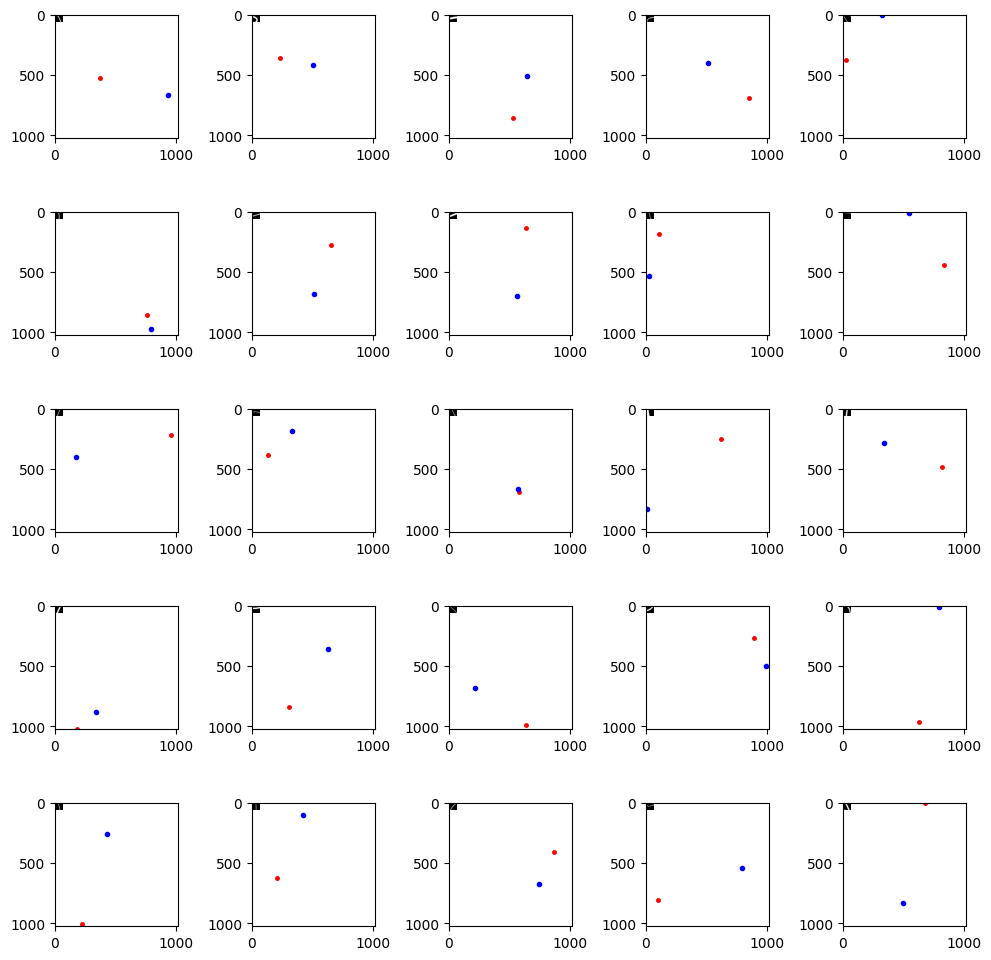

In [ ]:
def show_patches(data, number=64):
    indices = np.random.choice(len(data), number, replace=False)
    #indices = range(100000,100064)


    images = []
    xy_dat = []
    center = []

    for i in indices:
        inputs, outputs = data[i]
        images.append(inputs["patch"])
        xy_dat.append(outputs["ai_norm"])
        center.append(inputs["center"])

    import matplotlib.pyplot as plt

    grid_size = int(np.ceil(np.sqrt(number)))
    fix, axes = plt.subplots(grid_size, grid_size, figsize=(10,10))
    axes = axes.flatten()

    for i in range(grid_size * grid_size):
        if i < len(images):
            axes[i].imshow(images[i].numpy(), cmap='gray')
            axes[i].plot(xy_dat[i][0::2],xy_dat[i][1::2], 'r.', markersize=5)
            axes[i].plot(center[i][0::2],center[i][1::2], 'r.', color="blue")
            axes[i].set_xlim(0,1024)
            axes[i].set_ylim(1024,0)
        else:
            axes[i].remove()

    plt.tight_layout()
    plt.show()





show_patches(gaming)

In [6]:
class RoboTurbosky(t.nn.Module):
    #some sort of CNN
    #like the news company
    def __init__(self, config):
        super().__init__()

        self.net = t.nn.Sequential(
            t.nn.Conv2d(1, 64, kernel_size=5, padding=2),
            t.nn.ReLU(),
            t.nn.Conv2d(64, 128, kernel_size=5, padding=2),
            t.nn.ReLU(),
            t.nn.AdaptiveAvgPool2d(1),
            t.nn.Flatten(),
            t.nn.Linear(128, config["output_size"])
        )

        # #x, y, z
        # self.position_head = t.nn.Sequential(
        #     t.nn.Linear(config["hidden1"], config["pos_head_sz"]),
        #     t.nn.ReLU(),
        #     t.nn.Linear(config["pos_head_sz"], 3)
        # )

        # #speed, gas, brake,
        # self.control_head = t.nn.Sequential(
        #     t.nn.Linear(config["hidden1"] + 3, config["cont_head_sz"]),
        #     t.nn.ReLU(),
        #     t.nn.Linear(config["cont_head_sz"], 3)
        # )

    def forward(self, x):
        # encoded = self.encoder(x)
        # encoded = t.mean(encoded, dim=2)

        # position = self.position_head(encoded)
        # control_in = t.cat([encoded, position], dim=1)
        # control = self.control_head(control_in)

        #return position, control

        x = x.unsqueeze(1)
        return self.net(x)


In [7]:
dataloader = DataLoader(
    gaming,
    batch_size = 32,
    shuffle=True,
    #num_workers = 4,
    #pin_memory=True
)

In [8]:
# device = config["device"]
# model = RoboTurbosky(config)
# model.to(device)
# crit  = t.nn.MSELoss()
# optimizer = t.optim.Adam(model.parameters(), lr=config["learning_rate"])
# for epoch in tqdm(range(config["epochs"])):
    
#     bar = tqdm(dataloader, desc="Inner loop, No more details.")
#     for inputs, outputs in bar:
#         inputs = {k: v.to(device) for k,v in inputs.items()}
#         outputs= {k: v.to(device) for k,v in outputs.items()}
#         optimizer.zero_grad()
#         pred = model(inputs["patch"])
#         loss = crit(pred, outputs["ai_norm"])

#         loss.backward()
#         optimizer.step()
#         bar.set_postfix({"Loss" : loss})

# spencer = model